### Utility

In [1]:
from ase.cluster import Decahedron, Icosahedron, Octahedron, wulff_construction
from ase import Atoms 
from ase.io import Trajectory
import pandas as pd
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
import numpy as np

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode, EstimatorMethodType
from ase.io import Trajectory, write
from ase.build import bulk, surface, molecule, add_adsorbate, fcc111
from ase.constraints import ExpCellFilter, StrainFilter, FixAtoms, FixedPlane, FixBondLength
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.io.vasp import read_vasp, write_vasp
from ase.io import read
import pandas as pd
import ipywidgets as widgets
from IPython.display import display_png, Image as ImageWidget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import glob
from pathlib import Path
from PIL import Image, ImageDraw
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np
from scipy.spatial.distance import cdist

def visual2(structure,title,  max_size=(100, 100), rotation='15z,-90x',celloff=True):
    def calculate_stretch_factor(cell):
        """Calculate the stretch factor for visualization based on the cell dimensions."""
        x_length = cell[0][0]
        y_length = cell[1][1]

        # Avoid division by zero
        if y_length == 0:
            return 1.0

        stretch_y = y_length / x_length
        return stretch_y

    # Calculate stretch factor based on the structure's cell
    stretch_y = calculate_stretch_factor(structure.cell)
    temp=structure.copy()
    if celloff==True:
      temp.cell = None
    # Visualize the structure
    renderer = write('./temp.pov', temp, rotation=rotation)
    renderer.render()
    image_path = f'./temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    img.info['dpi'] = 2000
    display(img)

    # Move files to output directory
    destination = './output/'
    files = ['./temp.ini', './temp.pov', './temp.png']

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        shutil.move(file, destination)
    original_image_path = os.path.join(destination, 'temp.png')
    new_image_path = os.path.join(destination, f'{title}.png')

    # Rename the image file
    os.rename(original_image_path, new_image_path)
    
#############################Calculator setting###################################
calc_mode="CRYSTAL" # including +U correction
model_version="v4.0.0"  # the latest model version
method_type=EstimatorMethodType.PFVM
estimator = Estimator(calc_mode=calc_mode, model_version=model_version, method_type=method_type)
calculator = ASECalculator(estimator)
##################################################################################

def get_opt_energy(atoms, fmax=0.05, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

the customization is not there yet.

In [2]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from ase.md.langevin import Langevin
from ase.md import MDLogger
from ase import units
from time import perf_counter
from copy import deepcopy
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.nvtberendsen import NVTBerendsen
from ase import units

def run_md_simulation_nvt(atoms, temperature, num_md_steps, num_interval, friction_coeff, traj_filename, log_filename,time_step):

    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)  # Set zero total momentum to avoid driftingW

    # run MD
    dyn = NVTBerendsen(atoms, time_step*units.fs, temperature_K = temperature, taut=taut*units.fs, loginterval=num_interval, trajectory=traj_filename)

    # Print statements
    def print_dyn():
        imd = dyn.get_number_of_steps()
        etot  = atoms.get_total_energy()
        temp_K = atoms.get_temperature()
        elapsed_time = perf_counter() - start_time
        print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {elapsed_time:.3f}")


    dyn.attach(print_dyn, interval=num_interval)
    dyn.attach(MDLogger(dyn, atoms,log_filename, header=True, peratom=True, mode="a"), interval=num_interval)

    # Now run the dynamics
    start_time = perf_counter()
    print(f"    imd     Etot(eV)    T(K)    elapsed_time(sec)")
    dyn.run(num_md_steps)
    simulation_time = perf_counter() - start_time
    print(f"Total simulation time: {simulation_time:.3f} seconds")

In [5]:
from ase.build import fcc111, molecule, add_adsorbate
ceo2 = read_vasp("../../ceo2_bulk")
ceo2.calc = calculator
mol = molecule("O2")
mol.calc = calculator
E_mol = get_opt_energy(mol)
E_bulk = get_opt_energy(ceo2)
print(E_bulk,len(ceo2))

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:58:16       -5.920261*       0.7392
LBFGS:    1 04:58:16       -5.920359*       0.7693
LBFGS:    2 04:58:16       -5.924292*       0.0295
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:58:16      -83.902071*       0.0008
-83.90207128888056 12


N termination: 1
how many fixed atoms: 840 out of 1680


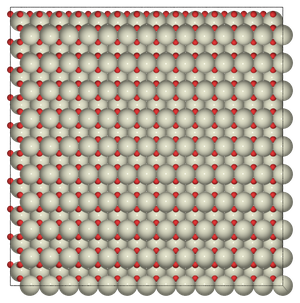

length and width : 55.154 A x 55.713 x 5.909  A
N_atoms: 1680
Composition: Ce: 560, O: 1120


In [14]:
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.build import make_supercell
import numpy as np
from collections import Counter
from scipy.spatial import distance

def fix_atoms(atoms):
    temp=atoms.copy()
    ce_positions = np.array([temp.position for temp in temp if temp.symbol == 'Ce'])
    ce_median_z = np.median(ce_positions[:, 2])
    mask = temp.positions[:, 2] < ce_median_z
    c = FixAtoms(mask=mask)
    temp.set_constraint(c)
    num_constrained_atoms = np.sum(mask)
    print("how many fixed atoms:", num_constrained_atoms, "out of", temp.get_global_number_of_atoms())
    
    return temp
def print_slab_info(atoms):
    # Calculate and print the size
    size_x = round(atoms.cell[0, 0], 3)
    size_y = round(atoms.cell[1, 1], 3)
    ce_positions = np.array([atom.position for atom in atoms if atom.symbol == 'Ce'])
    ce_min_z, ce_max_z = np.min(ce_positions[:, 2]), np.max(ce_positions[:, 2])
    size_z = round(ce_max_z-ce_min_z,3)
    print(f"length and width : {size_x} A x {size_y} x {size_z}  A")
    print(f"N_atoms: {len(atoms)}")
    symbols = atoms.get_chemical_symbols()
    element_counts = Counter(symbols)
    element_counts_line = ', '.join(f"{element}: {count}" for element, count in element_counts.items())
    print(f"Composition: {element_counts_line}")
    print("===============================")

def generate_slab(bulk, miller_index, supercell_dimensions,thick,fixoff=False):
    bulk_temp=bulk.copy()
    slab_gen = SlabGenerator(
        initial_structure=AseAtomsAdaptor.get_structure(bulk_temp),
        miller_index=miller_index,
        min_slab_size=thick,
        min_vacuum_size=40.0,
        lll_reduce=False,
        center_slab=True,
        primitive=True,
        max_normal_search=1,
    )
    
    slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)
    slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
    print('N termination:',len(slab_atoms_list))
    slab = slab_atoms_list[0].copy()
    slab = slab * supercell_dimensions
    
    # Shift `slab` to the bottom of the cell
    min_pos_z = np.min(slab.positions, axis=0)[2]
    slab.set_positions(slab.positions - [0, 0, min_pos_z])
    temp = slab.copy()
    if fixoff==False:
        temp = fix_atoms(temp)
        
    return temp

# Example usage:
m_110 = [1, 1, 0]
rod_size = (14, 10, 1)

rod_slab = generate_slab(ceo2, m_110, rod_size,6)
visual2(rod_slab,'rod_surf',(300, 300),'0z,-0x',celloff=False)
print_slab_info(rod_slab)

length and width : 0.0 A x 0.0 x 27.337  A
N_atoms: 2385
Composition: O: 1720, Ce: 665


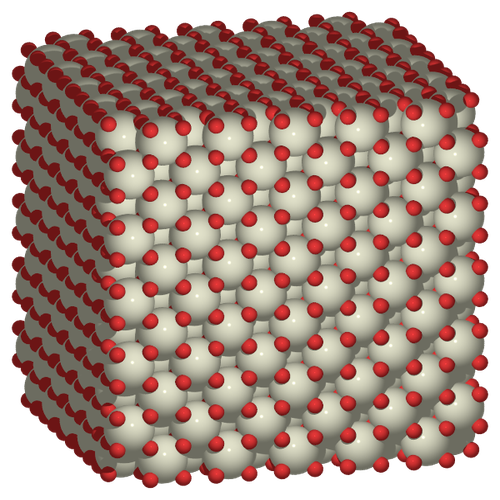

In [9]:
cube_2=read('./CeO2_03222024065326.xyz')
cube_2.pbc=True
print_slab_info(cube_2)
visual2(cube_2, f'test', (500, 500), rotation='15z,-75x', celloff=True)

In [15]:
from ase import Atoms
from ase.build import make_supercell
import numpy as np

def add_cluster_to_slab(rod_slab_hi, cube_down_hi, rotate_angle=None,rotate_axis='x'):
    rod_slab=rod_slab_hi.copy()
    cube_down=cube_down_hi.copy()
    slab_xy_size = np.min(rod_slab.cell.cellpar()[0:2])
    cluster_xy_size = np.max(
        (np.max(cube_down.positions, axis=0) - np.min(cube_down.positions, axis=0))[0:2]
    )
    # Vacuum size
    #print(slab_xy_size)

    slab_surface_xy_center = np.append(
        rod_slab.cell.cellpar()[0:2] / 2, np.max(rod_slab.positions, axis=0)[2]
    )
    cluster_surface_xy_center = np.append(
        np.mean(cube_down.positions, axis=0)[0:2], np.min(cube_down.positions, axis=0)[2]
    )
    if rotate_angle is not None:
        cube_down.rotate(rotate_angle, rotate_axis, center='com') # rotate_axis='z' for xy rotation, x for yz rotation 
        #cube_down.rotate(90, 'z', center='com')
    
    cube_loading = Atoms(cube_down.get_chemical_symbols(), cube_down.positions - cluster_surface_xy_center)
    cube_loading.translate(
        slab_surface_xy_center + [0, 0, 2]
    )

    mace_slab = rod_slab.copy()
    mace_slab += cube_loading

    return mace_slab

In [16]:
import random

def get_all_surf_o_atoms(slab):
    temp = slab.copy()
    ce_indices = [atom.index for atom in temp if atom.symbol == 'Ce']
    o_indices = [atom.index for atom in temp if atom.symbol == 'O']
    o_positions = np.array([atom.position for atom in temp if atom.symbol == 'O'])
    surf_indices = []  # List to store unique indices
    for atom in temp:
        for i in [0, 1, 2]:
            if np.abs(atom.position[i] - np.min(o_positions[:, i])) < 0.2 or np.abs(atom.position[i] - np.max(o_positions[:, i])) < 0.2:
                if atom.index not in surf_indices:  # Check if index is already in the list
                    surf_indices.append(atom.index)  # Add unique index to the list
    print(len(surf_indices))
    excess_o_atoms=len(o_indices)-len(ce_indices)*2
    print("excess_o_atoms", excess_o_atoms)
    print(slab)
    selected_indices = random.sample(surf_indices, excess_o_atoms)  # Randomly select 100 indices
    del temp[selected_indices]
    #visual2(temp, f'test', (500, 500), rotation='15z,-75x', celloff=True)
    return temp
    
rand_cubes_stoi=[]
for i in range(0,10):
 rand_cubes_stoi.append(get_all_surf_o_atoms(cube_2))

720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True)


In [19]:
post_md_relax_maces=[]
post_md_static_relax_maces=[]
pre_relax_maces=[]
for cube_down in rand_cubes_stoi:
    temp = add_cluster_to_slab(rod_slab, cube_down)
    pre_relax_maces.append(temp)
    #visual2(temp, f'test', (100, 100), rotation='15z,-75x', celloff=True)
write(f'./pre_relax_maces.traj',pre_relax_maces)


In [ ]:
for i,strs in enumerate(pre_relax_maces):
    atoms = strs.copy()
    atoms.calc = calculator
    time_step    = 1   # fsec
    temperature = 400+273
    num_md_steps = 1E+5 # 1ps, 100ps ~1000ps
    num_interval = 1E+3
    friction_coeff = 0.002
    taut         = 1.0    # fs
    traj_filename = f"./output/rand_mace_{i}.traj"
    log_filename = f"./output/rand_mace_{i}.log"
    run_md_simulation_nvt(atoms, temperature, num_md_steps, num_interval, friction_coeff, traj_filename, log_filename,time_step)
    post_md_relax_maces.append(atoms)
write(f'./post_md_relax_maces.traj',post_md_relax_maces)


    imd     Etot(eV)    T(K)    elapsed_time(sec)
    0   -23859.396    1130.90    0.205
   50   -24332.612    674.02    57.962
  100   -24366.137    674.71    161.715
  150   -24374.872    676.40    216.863
  200   -24392.199    671.48    300.074
  250   -24390.499    675.59    343.939
  300   -24413.991    674.96    397.044
  350   -24410.549    675.05    464.188
  400   -24406.160    671.96    558.399
  450   -24398.996    668.81    615.763
  500   -24399.781    675.20    657.523
  550   -24413.462    673.06    706.396
  600   -24412.798    673.15    779.846
  650   -24406.928    671.73    863.117
  700   -24415.589    672.77    932.546
  750   -24430.145    673.11    986.248
  800   -24428.483    672.79    1055.003
  850   -24420.836    674.34    1109.914
  900   -24432.458    673.70    1147.460
  950   -24439.491    671.68    1237.045
  1000   -24431.214    675.17    1306.740
Total simulation time: 1306.742 seconds
    imd     Etot(eV)    T(K)    elapsed_time(sec)
    0   -23798.5

In [ ]:
for structure in post_md_relax_maces:
    temp=structure.copy()
    get_opt_energy(temp,0.05)
    post_md_static_relax_maces.append(temp)
write('./post_md_static_relax_maces.traj',post_md_static_relax_maces)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def parse_log_file(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    run_data = []
    for line in lines:
        if "Time[ps]" not in line:
            try:
                tokens = line.split()
                time, etot, temp = float(tokens[0]), float(tokens[1]), float(tokens[4])
                run_data.append((time, etot, temp))
            except (ValueError, IndexError):
                pass

    return run_data

def plot_log_data(log_data):
    size = 8
    fig, ax1 = plt.subplots(figsize=(2, 1))
    time = [row[0] for row in log_data]
    etot = [row[1] for row in log_data]
    temp = [row[2] for row in log_data]
    ax1.plot(time[1:], etot[1:], color='tab:red', label='Etot', alpha=0.7)
    ax2 = ax1.twinx()
    ax2.plot(time[1:], temp[1:], color='tab:blue', label='Temp', alpha=0.7)
    ax1.set_xlabel('Time (ps)', fontsize=size)
    ax1.set_ylabel('Etot (eV)', color='tab:red', fontsize=size)
    ax2.set_ylabel('Temperature (K)', color='tab:blue', fontsize=size)
    ax1.legend(loc='upper left', fontsize=size)
    ax2.legend(loc='upper right', fontsize=size)
    ax1.tick_params(axis='both', labelsize=size)
    ax2.tick_params(axis='both', labelsize=size)
    plt.grid(True)
    plt.show()


for i,structure in post_md_relax_maces:
    log_filename = f'./output/rand_mace_{i}.log'
    log = parse_log_file(log_filename)
    plot_log_data(log)


In [ ]:
def plot_indices(indices):
    plt.figure(figsize=(5, 3))
    plt.plot(indices, 'bo')  # Plotting indices along the x-axis
    plt.xlabel('Index')
    plt.ylabel('energy per atom')
    plt.grid(True)
    plt.show()
total_atom_num=len(post_md_static_relax_maces)
print(total_atom_num)
energy_list=[structure.get_total_energy() for structure in post_md_static_relax_maces]
energy_list_per_atom=np.array(energy_list)/total_atom_num
# Plot the indices
plot_indices(energy_list_per_atom)

min_energy_index = np.argmin(energy_list_per_atom)
best_structure=post_md_static_relax_maces[min_energy_index]
print(min_energy_index)
print(np.min(energy_list_per_atom))
visual2(best_structure, f'test', (300, 300), rotation='15z,-75x', celloff=True)
write('./best_mace_structure.traj',best_structure)